# Final Project: Game Prediction

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from random import sample
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
team_data = pd.read_csv("MRegularSeasonDetailedResults.csv")
team_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [3]:
team_data = team_data[team_data['Season'] == 2022].copy().reset_index(drop = True)

In [4]:
#calculating possesions for win
# to calculate defensive efficiency we need to estimate possessions i will use the Dean Oliver method
# poss = FGA + ((.4 * FTA) - ((1.07 * ORB_Pct) * (FGA - FGM))) + TOV
#where ORB_Pct = oRB / (ORB + OPP_DRB)
for x in team_data:
    WPos = team_data.WFGA + ((.4 + team_data.WFGM) - 
                                      ((1.07 * (team_data.WOR/ (team_data.WOR + team_data.LOR)) *
                                        (team_data.WFGA - team_data.WFGM)))) + team_data.WTO
team_data['WPos'] = WPos.round(2)

In [5]:
#calculating possesions for loss
for x in team_data:
    LPos = team_data.LFGA + ((.4 + team_data.LFGM) - 
                                      ((1.07 * (team_data.LOR/ (team_data.LOR + team_data.WOR)) *
                                        (team_data.LFGA - team_data.LFGM)))) + team_data.LTO
team_data['LPos'] = LPos.round(2)

In [6]:
#calculating offensive efficiency for win
for x in team_data:
    WOE = (team_data.WScore / team_data.WPos) * 100
team_data['WOE'] = WOE.round(2)
#offensive effeiciency is other teams defensive efficency
team_data['LDE'] = WOE.round(2)

In [7]:
#calculating offensive efficency for 
for x in team_data:
    LOE = (team_data.LScore / team_data.LPos) * 100 
team_data['LOE'] = LOE.round(2)
team_data['WDE'] = LOE.round(2)

In [8]:
#true shooting percentage is PTS / (2*TSA) where TSA is FGA + .44 + FTA
for x in team_data: 
    WTSA = team_data.WScore / (2 * (team_data.WFGA + .44 * team_data.WFTA))
team_data['WTSA'] = WTSA.round(2)

In [9]:
for x in team_data: 
    LTSA = team_data.LScore / (2 * (team_data.LFGA + .44 * team_data.LFTA))
team_data['LTSA'] = LTSA.round(2)

In [10]:
#points per possession
for x in team_data: 
    WPPP = team_data.WScore / team_data.WPos
team_data['WPPP'] = WPPP.round(2)

In [11]:
for x in team_data: 
    LPPP = team_data.LScore / team_data.LPos
team_data['LPPP'] = LPPP.round(2)

In [12]:
team_data['Wwins'] = team_data.groupby('WTeamID').cumcount()

In [13]:
team_data['L_loss'] = team_data.groupby('LTeamID').cumcount()

In [14]:
#winning team losses 
WTeam_losses = []
for index,row in team_data.iterrows():
    winning_id = row['WTeamID']
    losses = (team_data[0:index].LTeamID.values==winning_id).sum()
    WTeam_losses.append(losses)
team_data['W_loss'] = WTeam_losses

In [15]:
#losing team wins
LTeam_wins = []
for index,row in team_data.iterrows():
    losing_id = row['LTeamID']
    wins = (team_data[0:index].WTeamID.values==losing_id).sum()
    LTeam_wins.append(wins)
team_data['L_wins'] = LTeam_wins

In [16]:
#total games
team_data['W_total_games'] = (team_data.Wwins + team_data.W_loss)
team_data['L_total_games'] = (team_data.L_loss + team_data.L_wins)

# Descriptive Stats

In [17]:
team_data[['WPPP', 'LPPP', 'WDE', 'LDE', 'WTSA', 'LTSA', 'WDR','LDR', 'WStl', 'LStl']].describe().round(2)

,WPPP,LPPP,WDE,LDE,WTSA,LTSA,WDR,LDR,WStl,LStl
count,5344.00,5344.00,5344.00,5344.00,5345.00,5345.00,5345.00,5345.00,5345.00,5345.00
mean,0.96,0.85,85.36,95.88,0.58,0.50,25.36,21.46,6.82,6.03
std,0.10,0.11,11.17,10.03,0.07,0.07,4.73,4.38,3.01,2.69
min,0.63,0.39,39.24,62.59,0.37,0.24,11.00,6.00,0.00,0.00
25%,0.89,0.78,77.95,89.07,0.53,0.45,22.00,18.00,5.00,4.00
50%,0.95,0.85,85.06,95.38,0.58,0.50,25.00,21.00,6.00,6.00
75%,1.02,0.92,92.41,102.10,0.63,0.54,28.00,24.00,9.00,8.00
max,1.43,1.31,131.24,143.05,0.84,0.77,44.00,44.00,22.00,19.00


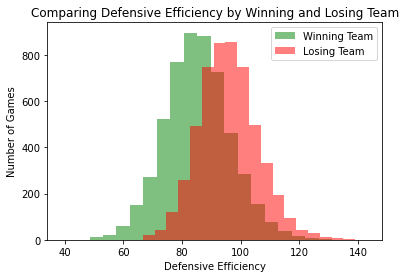

In [18]:
plt.hist(team_data.WDE, 20, color = "Green", alpha = .5)
plt.hist(team_data.LDE, 20, color = "Red", alpha = .5)
plt.xlabel("Defensive Efficiency")
plt.ylabel("Number of Games")
plt.title("Comparing Defensive Efficiency by Winning and Losing Team")
plt.legend(['Winning Team', 'Losing Team'])
#plt.savefig("Defensive_Efficiency")

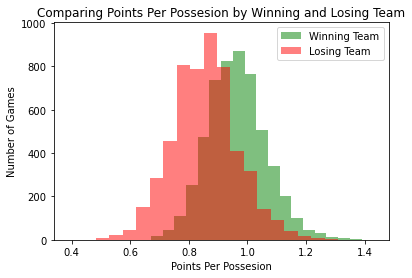

In [19]:
plt.hist(team_data.WPPP, 20, color = "Green", alpha = .5)
plt.hist(team_data.LPPP, 20, color = "Red", alpha = .5)
plt.xlabel("Points Per Possesion")
plt.ylabel("Number of Games")
plt.title("Comparing Points Per Possesion by Winning and Losing Team")
plt.legend(['Winning Team', 'Losing Team'])
#plt.savefig("PointsPerPossesion", format = 'png')

## Data Manipulation

In [20]:
swapped_df = team_data.copy()

In [21]:
#replacing winning and losing team with t1 and t2
swapped_df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(swapped_df.columns)]

In [22]:
swapped_df.rename(columns= {'T1_T2_oc': 'WLoc'}, 
                  inplace= True)

In [23]:
swapped_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,WLoc,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_Pos,T2_Pos,T1_OE,T2_DE,T2_OE,T1_DE,T1_TSA,T2_TSA,T1_PPP,T2_PPP,T1_wins,T2__loss,T1__loss,T2__wins,T1__total_games,T2__total_games
0,2022,8,1104,93,1256,64,H,0,32,64,13,33,16,23,14,34,19,13,9,2,19,26,67,6,26,6,19,14,20,11,10,3,1,18,92.28,81.46,100.78,100.78,78.57,78.57,0.63,0.42,1.01,0.79,0,0,0,0,0,0
1,2022,8,1105,82,1398,73,H,0,31,71,7,17,13,21,14,23,16,8,6,1,10,30,72,11,27,2,5,14,27,12,14,5,2,16,89.00,93.93,92.13,92.13,77.72,77.72,0.51,0.49,0.92,0.78,0,0,0,0,0,0
2,2022,8,1110,77,1265,73,H,1,27,59,5,19,18,26,7,29,17,14,5,4,12,31,68,4,19,7,12,10,26,5,15,6,3,20,86.30,91.11,89.22,89.22,80.12,80.12,0.55,0.50,0.89,0.80,0,0,0,0,0,0
3,2022,8,1112,81,1319,52,H,0,28,69,8,25,17,24,14,28,25,6,11,9,16,19,53,5,16,9,17,11,28,11,20,3,1,22,78.83,76.39,102.75,102.75,68.07,68.07,0.51,0.43,1.03,0.68,0,0,0,0,0,0
4,2022,8,1113,76,1339,60,H,0,31,66,7,26,7,9,13,29,15,19,10,3,16,22,54,6,24,10,11,2,22,10,21,9,1,14,83.94,92.83,90.54,90.54,64.63,64.63,0.54,0.51,0.91,0.65,0,0,0,0,0,0


### Average

In [24]:
test = swapped_df.copy()
test

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,WLoc,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_Pos,T2_Pos,T1_OE,T2_DE,T2_OE,T1_DE,T1_TSA,T2_TSA,T1_PPP,T2_PPP,T1_wins,T2__loss,T1__loss,T2__wins,T1__total_games,T2__total_games
0,2022,8,1104,93,1256,64,H,0,32,64,13,33,16,23,14,34,19,13,9,2,19,26,67,6,26,6,19,14,20,11,10,3,1,18,92.28,81.46,100.78,100.78,78.57,78.57,0.63,0.42,1.01,0.79,0,0,0,0,0,0
1,2022,8,1105,82,1398,73,H,0,31,71,7,17,13,21,14,23,16,8,6,1,10,30,72,11,27,2,5,14,27,12,14,5,2,16,89.00,93.93,92.13,92.13,77.72,77.72,0.51,0.49,0.92,0.78,0,0,0,0,0,0
2,2022,8,1110,77,1265,73,H,1,27,59,5,19,18,26,7,29,17,14,5,4,12,31,68,4,19,7,12,10,26,5,15,6,3,20,86.30,91.11,89.22,89.22,80.12,80.12,0.55,0.50,0.89,0.80,0,0,0,0,0,0
3,2022,8,1112,81,1319,52,H,0,28,69,8,25,17,24,14,28,25,6,11,9,16,19,53,5,16,9,17,11,28,11,20,3,1,22,78.83,76.39,102.75,102.75,68.07,68.07,0.51,0.43,1.03,0.68,0,0,0,0,0,0
4,2022,8,1113,76,1339,60,H,0,31,66,7,26,7,9,13,29,15,19,10,3,16,22,54,6,24,10,11,2,22,10,21,9,1,14,83.94,92.83,90.54,90.54,64.63,64.63,0.54,0.51,0.91,0.65,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340,2022,132,1222,71,1272,53,N,0,25,58,8,24,13,19,13,21,20,9,10,3,16,22,51,1,10,8,14,9,25,15,15,5,4,19,71.54,75.71,99.25,99.25,70.00,70.00,0.53,0.46,0.99,0.70,28,9,5,21,33,30
5341,2022,132,1234,75,1345,66,N,0,26,61,8,28,15,23,10,20,15,6,13,3,17,25,59,5,20,11,17,17,31,13,17,4,2,22,79.53,78.49,94.30,94.30,84.09,84.09,0.53,0.50,0.94,0.84,25,6,9,27,34,33
5342,2022,132,1350,64,1172,62,N,0,22,51,5,16,15,18,4,29,8,11,5,0,17,19,51,9,27,15,17,4,26,12,9,4,2,16,68.88,62.28,92.92,92.92,99.55,99.55,0.54,0.53,0.93,1.00,22,5,12,26,34,31
5343,2022,132,1397,65,1401,50,N,0,22,56,12,28,9,14,12,29,19,13,8,4,14,16,51,4,19,14,18,10,24,6,12,6,0,14,71.56,62.38,90.83,90.83,80.15,80.15,0.52,0.42,0.91,0.80,25,11,7,22,32,33


In [25]:
#add game id as reference
test['gameID'] = range(test.shape[0])

In [26]:
#make data long so each row is one teams data for one game 
df_list = []
for i in range(1,3):
        tmp = test[["gameID", f"T{i}_TeamID", f"T{i}_Score", f"T{i}_FGM", f"T{i}_FGA", f"T{i}_FGM3", f"T{i}_FGA3", f"T{i}_FTM",
              f"T{i}_FTA", f"T{i}_OR", f"T{i}_DR", f"T{i}_Ast", f"T{i}_TO", f"T{i}_Stl", f"T{i}_Blk", f"T{i}_PF",
             f"T{i}_Pos", f"T{i}_OE", f"T{i}_DE", f"T{i}_TSA", f"T{i}_PPP", f"T{i}__total_games"]].copy()
        tmp.columns = ["gameID", 'team_id', "Score", 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl',
                  'Blk', 'PF', 'Pos', 'OE', 'DE', 'TSA', 'PPP', 'total_games']
        df_list.append(tmp)
        df_long = pd.concat(df_list)

In [27]:
df_long = df_long.sort_values("gameID").reset_index(drop= True)

In [28]:
df_long.head()

,gameID,team_id,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Pos,OE,DE,TSA,PPP,total_games
0,0,1104,93,32,64,13,33,16,23,14,34,19,13,9,2,19,92.28,100.78,78.57,0.63,1.01,0
1,0,1256,64,26,67,6,26,6,19,14,20,11,10,3,1,18,81.46,78.57,100.78,0.42,0.79,0
2,1,1398,73,30,72,11,27,2,5,14,27,12,14,5,2,16,93.93,77.72,92.13,0.49,0.78,0
3,1,1105,82,31,71,7,17,13,21,14,23,16,8,6,1,10,89.00,92.13,77.72,0.51,0.92,0
4,2,1110,77,27,59,5,19,18,26,7,29,17,14,5,4,12,86.30,89.22,80.12,0.55,0.89,0


In [29]:
#get average data for each variable and shift so current cell contains average for previous games
def average(stat):
    df_long[f'avg_{stat}']= (df_long.groupby('team_id')[stat].
                              apply(lambda x : x.shift().cumsum()).values/df_long.total_games).round(2)

In [30]:
average('Score')
average('FGM')
average('FGA')
average('FGM3')
average('FGA3')
average('FTA')
average('FTM')
average('OR')
average('DR')
average('Ast')
average('TO')
average('Stl')
average('Blk')
average('PF')
average('Pos')
average('OE')
average('DE')
average('TSA')
average('PPP')

In [31]:
#getting columns to use
cols =  df_long.columns[df_long.columns.str.startswith('avg')].tolist()
#adding other necessary columns
cols = cols + ['gameID', 'team_id', 'Score']
print(cols)
average_long = df_long[['avg_Score', 'avg_FGM', 'avg_FGA', 'avg_FGM3', 'avg_FGA3', 'avg_FTA', 'avg_FTM', 'avg_OR', 'avg_DR', 
         'avg_Ast', 'avg_TO', 'avg_Stl', 'avg_Blk', 'avg_PF', 'avg_Pos', 'avg_OE', 'avg_DE', 'avg_TSA', 'avg_PPP',
         'gameID', 'team_id', 'Score', 'total_games']]

['avg_Score', 'avg_FGM', 'avg_FGA', 'avg_FGM3', 'avg_FGA3', 'avg_FTA', 'avg_FTM', 'avg_OR', 'avg_DR', 'avg_Ast', 'avg_TO', 'avg_Stl', 'avg_Blk', 'avg_PF', 'avg_Pos', 'avg_OE', 'avg_DE', 'avg_TSA', 'avg_PPP', 'gameID', 'team_id', 'Score']


In [32]:
even = []
odd = []
#create two lists each with one team from each game- since they are sorted by game id I am using the index 
for i in range(0,10690):
    if i == 0 or i % 2:
        even.append(average_long.iloc[i])
    else:
        odd.append(average_long.iloc[i])
even = pd.DataFrame(even)
even2 = even.drop(['gameID', 'team_id'], axis = 1)
even2.columns = [f'T1_{col}' for col in list(even2.columns)]
even2['gameID']= even['gameID'] 
even2['team_id'] = even['team_id']


In [33]:
odd = pd.DataFrame(odd)
odd2 = odd.drop(['gameID', 'team_id'], axis = 1)
odd2.columns = [f'T2_{col}' for col in list(odd2.columns)]
odd2['gameID'] = odd['gameID'] 
odd2['team_id'] = odd['team_id']

In [34]:
#merge 
average_df = even2.merge(odd2, on = 'gameID', how = 'left')

In [35]:
average_df = average_df.rename(columns={'team_id_x': 'T1_TeamID', 'team_id_y': 'T2_TeamID'})

In [36]:
#get only average data and scores
average_df = average_df[['T1_avg_Score', 'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3', 'T1_avg_FGA3', 'T1_avg_FTA', 
                         'T1_avg_FTM', 'T1_avg_OR', 'T1_avg_DR', 'T1_avg_Ast', 'T1_avg_TO', 'T1_avg_Stl', 
                         'T1_avg_Blk', 'T1_avg_PF', 'T1_avg_Pos', 'T1_avg_OE', 'T1_avg_DE', 'T1_avg_TSA', 
                         'T1_avg_PPP', 'T2_avg_Score','T2_avg_FGM', 'T2_avg_FGA', 'T2_avg_FGM3', 'T2_avg_FGA3',
                         'T2_avg_FTA', 'T2_avg_FTM', 'T2_avg_OR', 'T2_avg_DR', 'T2_avg_Ast', 'T2_avg_TO', 
                         'T2_avg_Stl', 'T2_avg_Blk', 'T2_avg_PF', 'T2_avg_Pos', 'T2_avg_OE', 'T2_avg_DE', 
                         'T2_avg_TSA', 'T2_avg_PPP', 'T1_Score', 'T2_Score']]

In [37]:
#switch t1 and t2 around so t1 does not always win 

In [38]:
T1 = [col for col in average_df if col.startswith('T1')]
T2 = [col for col in average_df if col.startswith('T2')]

In [39]:
np.random.seed(13)
random_rows = np.random.choice(average_df.index, size=average_df.shape[0]//2, replace=False)
average_df.loc[random_rows, T1+T2] = average_df.loc[random_rows, T2+T1].values

In [40]:
average_df['outcome']= np.where(average_df.T1_Score > average_df.T2_Score,1,0)
#check tail since head will be NA 
average_df.tail(10)

,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTA,T1_avg_FTM,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_Pos,T1_avg_OE,T1_avg_DE,T1_avg_TSA,T1_avg_PPP,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTA,T2_avg_FTM,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_Pos,T2_avg_OE,T2_avg_DE,T2_avg_TSA,T2_avg_PPP,T1_Score,T2_Score,outcome
5336,79.35,29.16,62.65,7.84,20.52,17.94,13.19,10.13,24.48,13.03,11.16,9.06,4.16,16.97,82.80,95.80,84.06,0.56,0.96,73.70,26.07,57.93,8.27,23.80,18.17,13.30,7.43,24.87,13.23,11.23,6.43,1.93,14.87,79.84,92.15,89.16,0.56,0.92,82.0,73.0,1
5337,74.37,25.50,56.77,9.40,24.37,17.83,13.97,6.13,23.53,12.57,10.80,4.70,2.00,13.73,79.44,93.31,90.68,0.57,0.93,74.52,27.13,55.35,8.87,24.19,15.19,11.39,5.81,25.90,15.00,9.42,5.13,2.45,13.97,76.87,96.85,85.62,0.60,0.97,43.0,82.0,0
5338,69.69,25.97,57.16,6.81,21.62,15.00,10.94,8.12,27.47,13.28,13.44,5.44,4.47,13.44,81.09,85.67,86.72,0.55,0.86,73.22,24.78,56.28,9.34,25.72,17.31,14.31,8.72,22.94,12.16,9.44,6.25,2.31,15.41,72.54,100.80,86.12,0.58,1.01,48.0,54.0,0
5339,80.58,29.85,61.12,8.30,22.30,17.18,12.58,9.61,26.55,17.03,9.91,6.52,5.42,13.61,83.87,96.26,83.80,0.59,0.96,70.41,25.82,55.00,8.97,22.91,13.15,9.79,7.35,22.65,14.29,10.50,5.32,3.29,14.65,75.49,93.45,86.26,0.58,0.94,67.0,82.0,0
5340,72.44,26.85,60.04,8.07,24.04,14.59,10.67,7.37,24.15,12.56,11.44,5.56,2.22,17.30,81.54,89.11,93.88,0.55,0.89,72.19,25.52,58.11,6.85,21.11,19.30,14.30,7.67,25.26,12.00,12.78,6.11,3.15,17.96,79.88,90.62,90.76,0.54,0.91,61.0,67.0,0
5341,76.17,27.10,57.43,6.50,17.87,22.27,15.47,11.13,24.30,16.10,15.83,8.83,5.73,18.70,82.87,92.35,86.57,0.57,0.92,75.97,28.24,60.09,8.00,23.45,17.18,11.48,12.18,24.61,16.64,10.85,8.18,5.27,17.42,77.82,97.61,80.96,0.56,0.98,53.0,71.0,0
5342,80.21,28.33,57.18,8.85,22.42,20.88,14.70,9.58,25.67,16.73,11.18,4.64,3.55,14.12,79.05,101.49,86.51,0.60,1.02,84.03,30.03,64.56,9.32,25.18,19.47,14.65,10.59,23.82,16.12,8.85,7.24,4.41,16.12,83.53,100.51,86.26,0.57,1.00,66.0,75.0,0
5343,71.94,25.50,57.35,8.21,24.26,17.65,12.74,6.56,23.71,14.74,9.24,7.91,2.32,13.79,77.03,93.68,89.58,0.56,0.94,75.03,26.39,54.94,8.65,22.39,18.06,13.61,6.42,25.00,14.45,9.42,4.65,2.61,14.81,75.79,99.34,91.22,0.60,0.99,64.0,62.0,1
5344,72.61,25.76,58.09,6.82,20.15,20.55,14.27,9.73,21.70,13.67,13.00,9.97,3.48,18.27,79.62,91.24,86.56,0.54,0.91,73.44,26.00,60.28,8.66,24.34,17.91,12.78,10.44,23.81,16.03,11.88,9.31,4.38,17.06,77.43,95.17,82.01,0.54,0.95,50.0,65.0,0
5345,79.15,29.81,61.73,10.77,27.81,13.58,8.77,7.35,25.81,14.85,9.81,5.69,1.69,14.12,83.66,95.18,87.02,0.59,0.95,72.00,25.54,57.96,6.93,21.11,19.04,14.00,7.57,25.32,11.89,12.57,6.00,3.18,17.79,79.70,90.58,90.90,0.54,0.91,64.0,66.0,0


### Rolling Average - 10 game window 

In [41]:
#same process as average but with a 10 game moving window to average 
df_list = []
for i in range(1,3):
        tmp = test[["gameID", f"T{i}_TeamID", f"T{i}_Score", f"T{i}_FGM", f"T{i}_FGA", f"T{i}_FGM3", f"T{i}_FGA3", f"T{i}_FTM",
              f"T{i}_FTA", f"T{i}_OR", f"T{i}_DR", f"T{i}_Ast", f"T{i}_TO", f"T{i}_Stl", f"T{i}_Blk", f"T{i}_PF",
             f"T{i}_Pos", f"T{i}_OE", f"T{i}_DE", f"T{i}_TSA", f"T{i}_PPP", f"T{i}__total_games"]].copy()
        tmp.columns = ["gameID", 'team_id', "Score", 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl',
                  'Blk', 'PF', 'Pos', 'OE', 'DE', 'TSA', 'PPP', 'total_games']
        df_list.append(tmp)
        df_long = pd.concat(df_list)

In [42]:
df_long = df_long.sort_values("gameID").reset_index(drop= True)

In [43]:
#takes the average of the past 10 games not including the current cell
def rolling(stat):
    df_long[f'roll_{stat}']= ((df_long.groupby('team_id')[stat].
                       apply(lambda d: d.rolling(10, closed = 'left').sum()))
                       /10).round(2)

In [44]:
rolling('Score')
rolling('FGM')
rolling('FGA')
rolling('FGM3')
rolling('FGA3')
rolling('FTA')
rolling('FTM')
rolling('OR')
rolling('DR')
rolling('Ast')
rolling('TO')
rolling('Stl')
rolling('Blk')
rolling('PF')
rolling('Pos')
rolling('OE')
rolling('DE')
rolling('TSA')
rolling('PPP')

In [45]:
rolling_long= df_long[['gameID', 'team_id', 'Score', 'roll_Score', 'roll_FGM', 'roll_FGA',
       'roll_FGM3', 'roll_FGA3', 'roll_FTA', 'roll_FTM', 'roll_OR', 'roll_DR',
       'roll_Ast', 'roll_TO', 'roll_Stl', 'roll_Blk', 'roll_PF', 'roll_Pos',
       'roll_OE', 'roll_DE', 'roll_TSA', 'roll_PPP']]

In [46]:
even = []
odd = []
for i in range(0,10690):
    if i == 0 or i % 2:
        even.append(rolling_long.iloc[i])
    else:
        odd.append(rolling_long.iloc[i])

In [47]:
even = pd.DataFrame(even)
even.columns
even2 = even.drop(['gameID', 'team_id'], axis = 1)
even2.columns = [f'T1_{col}' for col in list(even2.columns)]
even2['gameID']= even['gameID'] 
even2['team_id'] = even['team_id']

In [48]:
odd = pd.DataFrame(odd)
odd2 = odd.drop(['gameID', 'team_id'], axis = 1)
odd2.columns = [f'T2_{col}' for col in list(odd2.columns)]
odd2['gameID'] = odd['gameID'] 
odd2['team_id'] = odd['team_id']

In [49]:
rolling_df = even2.merge(odd2, on = 'gameID', how = 'left')

In [50]:
average_df = average_df.rename(columns={'team_id_x': 'T1_TeamID', 'team_id_y': 'T2_TeamID'})

In [51]:
T1 = [col for col in rolling_df if col.startswith('T1')]
T2 = [col for col in rolling_df if col.startswith('T2')]

In [52]:
np.random.seed(13)
random_rows = np.random.choice(rolling_df.index, size=rolling_df.shape[0]//2, replace=False)
rolling_df.loc[random_rows, T1+T2] = rolling_df.loc[random_rows, T2+T1].values

In [53]:
rolling_df['outcome']= np.where(rolling_df.T1_Score> rolling_df.T2_Score,1,0)
rolling_df.tail(10)

,T1_Score,T1_roll_Score,T1_roll_FGM,T1_roll_FGA,T1_roll_FGM3,T1_roll_FGA3,T1_roll_FTA,T1_roll_FTM,T1_roll_OR,T1_roll_DR,T1_roll_Ast,T1_roll_TO,T1_roll_Stl,T1_roll_Blk,T1_roll_PF,T1_roll_Pos,T1_roll_OE,T1_roll_DE,T1_roll_TSA,T1_roll_PPP,gameID,team_id_x,T2_Score,T2_roll_Score,T2_roll_FGM,T2_roll_FGA,T2_roll_FGM3,T2_roll_FGA3,T2_roll_FTA,T2_roll_FTM,T2_roll_OR,T2_roll_DR,T2_roll_Ast,T2_roll_TO,T2_roll_Stl,T2_roll_Blk,T2_roll_PF,T2_roll_Pos,T2_roll_OE,T2_roll_DE,T2_roll_TSA,T2_roll_PPP,team_id_y,outcome
5336,82.0,79.2,28.4,60.4,8.2,21.1,19.0,14.2,9.9,25.9,13.4,11.6,7.6,4.3,17.2,79.73,99.46,87.78,0.57,0.99,5335.0,1412.0,73.0,68.8,24.2,55.2,7.4,21.1,17.8,13.0,6.1,24.8,11.1,11.4,5.6,1.8,15.0,76.62,88.86,88.60,0.54,0.89,1256.0,1
5337,43.0,79.1,26.5,54.8,10.1,22.2,19.7,16.0,5.5,22.5,12.5,9.7,4.4,2.0,12.8,80.07,98.46,95.21,0.62,0.98,5336.0,1436.0,82.0,76.4,27.6,57.1,9.2,25.2,16.4,12.0,6.9,27.5,15.9,9.2,5.1,3.0,12.6,77.03,99.30,79.20,0.60,0.99,1420.0,0
5338,48.0,73.7,27.0,57.8,7.8,22.9,16.3,11.9,8.0,27.9,14.7,12.3,5.2,3.4,12.5,81.96,89.83,86.93,0.57,0.90,5337.0,1437.0,54.0,74.8,24.9,54.9,9.0,24.6,19.3,16.0,8.2,22.5,11.1,11.1,6.2,2.4,15.3,75.72,99.07,91.88,0.59,0.99,1166.0,0
5339,67.0,81.5,30.1,60.5,9.1,23.5,16.3,12.2,9.0,26.0,16.3,8.7,4.9,5.4,13.4,82.51,98.78,89.39,0.60,0.99,5338.0,1439.0,82.0,69.2,24.8,55.6,8.0,24.5,15.1,11.6,7.2,23.5,13.9,9.6,5.9,3.8,14.7,72.91,95.10,85.64,0.56,0.95,1181.0,0
5340,61.0,75.5,28.8,62.4,6.4,21.9,15.3,11.5,8.2,26.5,11.0,10.7,5.4,2.1,18.6,82.94,91.20,94.52,0.55,0.91,5339.0,1335.0,67.0,71.7,25.9,55.0,5.1,16.2,19.4,14.8,6.9,25.1,11.4,13.6,7.3,3.6,15.5,79.82,90.21,85.76,0.57,0.90,1463.0,0
5341,53.0,74.9,26.3,55.8,6.4,16.7,20.5,15.9,11.2,24.7,16.6,15.1,9.1,5.0,17.3,80.11,94.04,85.08,0.58,0.94,5340.0,1222.0,71.0,73.2,27.4,58.6,7.1,22.6,16.5,11.3,11.8,24.3,17.8,11.7,7.7,4.9,17.8,76.62,95.78,86.41,0.56,0.96,1272.0,0
5342,66.0,70.3,24.9,53.6,6.8,19.5,19.6,13.7,7.8,23.6,13.3,11.5,3.7,3.5,13.6,74.79,94.22,89.13,0.56,0.94,5341.0,1234.0,75.0,84.0,29.8,63.3,10.3,24.7,19.1,14.1,10.7,23.8,15.5,9.9,5.2,4.1,16.1,83.94,100.31,87.10,0.59,1.00,1345.0,0
5343,64.0,69.5,23.7,54.0,7.1,20.8,20.2,15.0,5.7,24.1,12.7,9.2,6.4,2.4,14.3,73.26,95.12,91.18,0.55,0.95,5342.0,1350.0,62.0,73.6,26.0,56.4,8.0,23.1,18.9,13.6,6.6,26.7,13.5,7.9,4.0,3.3,14.2,75.10,98.03,89.53,0.57,0.98,1172.0,1
5344,50.0,73.4,25.4,56.9,6.1,18.1,21.1,16.5,8.5,22.6,13.6,13.0,9.4,2.4,19.0,79.44,92.32,89.47,0.56,0.92,5343.0,1397.0,65.0,71.0,24.0,57.4,7.6,19.3,20.7,15.4,9.6,25.2,13.9,11.2,7.9,4.1,18.1,73.93,96.89,88.58,0.54,0.97,1401.0,0
5345,64.0,79.5,29.9,61.7,11.5,29.0,13.8,8.2,7.4,26.7,14.7,9.0,5.4,1.6,13.7,84.32,94.31,85.97,0.59,0.94,5344.0,1343.0,66.0,70.4,25.7,55.0,5.4,17.0,18.3,13.6,6.9,24.8,11.4,12.8,6.9,3.6,14.8,78.50,90.08,85.72,0.56,0.90,1463.0,0


## Regressions

In [54]:
def logistic_model(Xtrain, Xtest, ytrain, ytest, x):
    #model
    logistic = LogisticRegression(max_iter= 10000)
    logistic.fit(Xtrain, ytrain)
    #get metrics
    score = logistic.score(Xtest, ytest)
    matrix = confusion_matrix(ytest, logistic.predict(Xtest))
    #feature importance
    feature_importance = pd.DataFrame({'Feature': x.columns, 'Value':logistic.coef_[0] })
    feature_importance = feature_importance.sort_values('Value', ascending=True)
    #print metrics
    print("Model Score:", score)
    print(matrix)
    return feature_importance.plot(x='Feature', y='Value', kind='barh', figsize=(10, 6))

In [55]:
def rf_model(Xtrain, Xtest, ytrain, ytest, x):
    #model
    rfmodel = RandomForestClassifier( random_state=13)
    rfmodel.fit(Xtrain, ytrain)
    #metrics
    score = rfmodel.score(Xtest, ytest)
    matrix = confusion_matrix(ytest, rfmodel.predict(Xtest))
    #feature importance
    feature_importance = pd.DataFrame({'Feature': x.columns, 'Value':rfmodel.feature_importances_ })
    feature_importance = feature_importance.sort_values('Value', ascending=True)
    print("Model Score:", score)
    print(matrix)
    return feature_importance.plot(x='Feature', y='Value', kind='barh', figsize=(10, 6))

### Average

#### Logistic

In [56]:
average_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [57]:
average_df = average_df.dropna(axis = 0)
average_df.shape

(5126, 41)

Model Score: 0.6929824561403509
[[346 154]
 [161 365]]


<AxesSubplot:ylabel='Feature'>

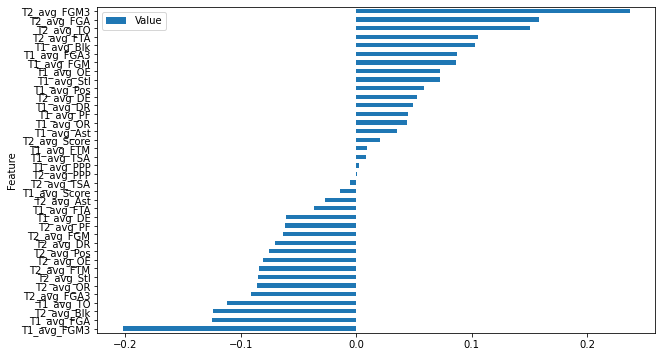

In [58]:
y = average_df.outcome
x= average_df.drop(['outcome', 'T1_Score','T2_Score'], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=13)
logistic_model(Xtrain, Xtest, ytrain, ytest, x)

### Random Forest

Model Score: 0.6617933723196882
[[330 170]
 [177 349]]


<AxesSubplot:ylabel='Feature'>

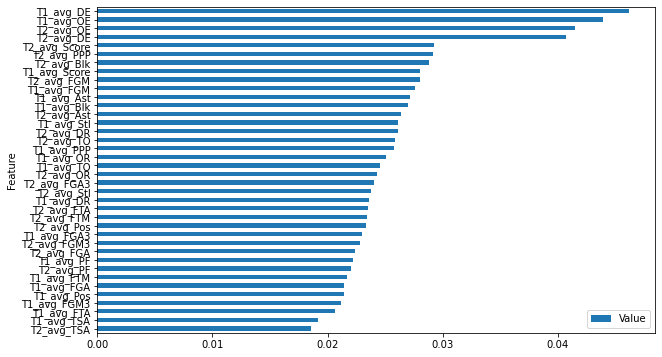

In [59]:
#independent and dependent
y = average_df.outcome
x= average_df.drop(['outcome', 'T1_Score','T2_Score'], axis=1)
#split
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=13)
rf_model(Xtrain, Xtest, ytrain, ytest, x)

## PCA

### Average

In [60]:
average_df = average_df.dropna(axis = 0)

scaler = StandardScaler()

y = average_df['outcome']

avg_pca = average_df.drop(['outcome', 'T1_Score', 'T2_Score'], axis = 1)
avg_pca.columns

Index(['T1_avg_Score', 'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3',
       'T1_avg_FGA3', 'T1_avg_FTA', 'T1_avg_FTM', 'T1_avg_OR', 'T1_avg_DR',
       'T1_avg_Ast', 'T1_avg_TO', 'T1_avg_Stl', 'T1_avg_Blk', 'T1_avg_PF',
       'T1_avg_Pos', 'T1_avg_OE', 'T1_avg_DE', 'T1_avg_TSA', 'T1_avg_PPP',
       'T2_avg_Score', 'T2_avg_FGM', 'T2_avg_FGA', 'T2_avg_FGM3',
       'T2_avg_FGA3', 'T2_avg_FTA', 'T2_avg_FTM', 'T2_avg_OR', 'T2_avg_DR',
       'T2_avg_Ast', 'T2_avg_TO', 'T2_avg_Stl', 'T2_avg_Blk', 'T2_avg_PF',
       'T2_avg_Pos', 'T2_avg_OE', 'T2_avg_DE', 'T2_avg_TSA', 'T2_avg_PPP'],
      dtype='object')

In [61]:
avg_pca = pd.DataFrame.from_records(scaler.fit_transform(avg_pca), 
                                     columns = avg_pca.columns)
avg_pca.head()

,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTA,T1_avg_FTM,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_Pos,T1_avg_OE,T1_avg_DE,T1_avg_TSA,T1_avg_PPP,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTA,T2_avg_FTM,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_Pos,T2_avg_OE,T2_avg_DE,T2_avg_TSA,T2_avg_PPP
0,2.813300,4.820728,1.927649,-0.207104,0.787056,-1.634408,-2.090764,0.236207,4.297262,3.786604,2.721776,0.866004,2.878635,-0.013279,5.805734,-0.928004,0.300753,2.585313,-0.857960,0.405944,-1.951830,-3.239506,-0.223353,-0.551992,5.337308,5.163463,-1.323272,-1.510530,-2.855106,5.644899,2.747752,-1.749334,4.033094,-0.344517,0.861218,0.994233,1.365610,0.791019
1,-3.835153,-4.195127,-1.102693,-0.207104,1.052384,-1.043843,-1.705781,-1.801631,1.406665,-1.972336,-0.301247,-1.020521,-1.772618,-1.373366,-3.413209,-2.886118,0.116283,-4.274697,-2.810179,-3.293848,-2.707238,-2.699629,-2.677494,0.241083,-0.738167,-1.694714,-2.889433,-2.332385,-2.436942,-2.764785,-0.989654,1.290740,1.338076,-2.519714,-2.730525,3.499010,-2.588002,-2.708400
2,0.691453,-0.438520,1.101192,0.988107,0.521729,2.499545,2.144050,0.236207,1.406665,0.495781,1.210265,0.866004,4.429053,2.706895,1.282006,-0.186933,0.915133,-0.599692,-0.257277,1.828941,2.202911,1.349451,-0.836888,-1.345067,1.576300,0.972355,2.331103,2.598746,1.744696,-0.291348,-0.366753,1.290740,-1.806112,0.385770,2.085919,-1.051811,0.871409,2.008208
3,1.398736,0.312801,-1.929149,-1.999922,-1.070235,5.452369,4.453948,-1.292171,-0.658047,1.318487,0.706428,0.237163,2.878635,0.440083,-0.046531,1.929335,-0.923316,1.605312,1.995285,2.255840,2.580615,3.239021,2.230788,2.355950,-0.448859,-0.551685,0.764942,5.064311,2.162860,1.687401,-2.235456,-1.749334,0.888906,3.880575,-0.320778,-0.285140,0.624308,-0.274022
4,3.944952,2.942425,1.101192,2.780924,2.113693,2.204263,2.914016,3.292963,0.167838,-1.972336,-0.301247,4.639054,-0.222200,-1.826728,1.374649,3.804606,-2.689853,3.320314,3.797334,-0.305554,-0.063311,-1.889813,0.390183,-1.080708,-0.738167,-0.932694,-2.889433,-3.565168,-2.855106,0.698026,2.747752,-0.229297,0.439737,1.211993,-1.412790,3.349802,1.365610,-1.339062


In [62]:
pca=PCA()
pca.fit(avg_pca)

PCA()

In [63]:
fd = pca.components_
matrix = np.transpose(fd)
df_fl = pd.DataFrame(data=matrix, index= avg_pca.columns,
                     columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', 
                              'Z15','Z16', 'Z17', 'Z18', 'Z19', 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z25', 'Z26', 'Z27', 
                              'Z28','Z29', 'Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z37', 'Z38'])
df_fl

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,Z38
T1_avg_Score,0.261506,0.265598,-0.012969,-0.026174,0.049580,0.008620,0.120723,-0.070702,0.027686,-0.021791,-0.083781,0.021726,-0.079998,0.070985,-0.003928,0.004560,-0.027184,-0.010460,-0.056719,-0.039336,0.101493,-0.069021,-0.030313,-0.015662,0.002374,0.006599,0.004521,-0.010891,-0.013589,-0.000594,-0.267483,-0.078769,0.177142,0.341584,0.001158,0.032942,-6.251292e-01,0.421910
T1_avg_FGM,0.236835,0.238490,-0.032560,-0.069428,0.166432,-0.070723,0.037486,-0.026591,0.133437,0.096061,-0.149028,0.032230,-0.204463,0.173187,-0.053614,-0.019259,0.081228,0.036435,0.007116,-0.027011,0.151530,-0.097971,-0.012009,-0.011004,0.013292,-0.055524,-0.058074,0.142412,0.308345,-0.063005,-0.256905,-0.071175,0.182122,0.354399,0.000653,0.033789,4.707501e-01,-0.317712
T1_avg_FGA,0.140915,0.144154,0.045068,-0.206847,0.225775,-0.246261,-0.005255,0.236155,-0.173603,-0.151625,0.069766,-0.089417,-0.264651,0.303025,0.081839,0.042168,-0.191979,-0.068299,-0.097737,-0.051368,-0.095369,0.043203,-0.097116,-0.047608,0.100293,0.406446,0.015040,-0.064050,-0.028437,-0.020767,0.460999,0.188206,0.061630,0.037926,-0.000260,0.020589,-6.439976e-05,-0.000085
T1_avg_FGM3,0.141930,0.144746,-0.286275,0.020247,0.254543,0.157710,0.038313,-0.007015,-0.204966,-0.211373,0.093148,-0.019592,0.219905,-0.239094,0.023686,0.042620,0.033429,-0.000697,0.012920,0.009638,0.096988,-0.077566,0.094069,0.118185,-0.116950,0.132813,0.317876,-0.589850,-0.095810,0.056317,-0.087951,-0.031429,0.044212,0.082456,-0.001127,0.010405,1.479710e-01,-0.099860
T1_avg_FGA3,0.093916,0.084696,-0.249601,-0.038784,0.271475,0.088320,0.002625,0.100023,-0.324706,-0.286364,0.238705,-0.071937,0.262876,-0.227934,0.073330,0.045553,-0.189660,-0.077697,-0.029598,0.039273,-0.026552,0.005508,-0.128310,-0.120058,0.049294,-0.277182,-0.242171,0.471337,0.113566,-0.037502,0.003210,0.004076,0.003741,0.011650,0.001332,0.000762,-5.612252e-06,-0.000001
T1_avg_FTA,0.120929,0.127859,0.270760,0.027402,-0.367426,0.014724,0.227646,-0.120052,-0.065318,-0.112415,0.053089,-0.011389,0.087738,-0.032975,0.050851,0.005127,-0.218743,-0.085598,-0.118166,-0.029716,-0.125325,0.076264,-0.053557,0.003675,-0.122867,-0.275429,0.155739,-0.230550,0.588421,-0.064207,0.205046,0.082073,0.014711,0.003835,-0.002981,0.009505,-2.633607e-05,-0.000043
T1_avg_FTM,0.134850,0.140781,0.215860,0.057996,-0.370178,0.066833,0.227015,-0.133409,-0.066136,-0.120035,0.017425,0.005706,0.059689,-0.007782,0.083849,0.024465,-0.261984,-0.102581,-0.177306,-0.057918,-0.096770,0.062965,-0.118341,-0.096291,0.054532,0.046271,-0.073441,0.058538,-0.607179,0.091326,-0.144701,-0.048315,0.080785,0.150169,0.002359,0.013755,2.297216e-01,-0.154982
T1_avg_OR,0.110248,0.101795,0.227971,-0.182199,-0.074864,-0.231745,-0.116809,0.300602,-0.216598,-0.087690,0.153447,-0.155327,-0.006637,0.086400,-0.189827,-0.156949,0.333571,0.088745,-0.164383,-0.245734,0.074564,-0.014231,0.291607,0.160099,-0.136239,-0.416594,0.014357,-0.011778,-0.194460,0.063984,-0.009462,-0.010054,-0.015911,-0.027359,0.001482,-0.002496,1.146344e-06,0.000018
T1_avg_DR,0.170557,0.133472,0.028752,0.010506,-0.012669,-0.068945,0.023024,-0.092685,0.209201,0.175287,0.493028,-0.311481,0.052482,0.128249,-0.081037,-0.103714,-0.207998,0.022961,0.325480,0.482391,-0.084010,-0.032628,0.264986,0.140502,-0.036399,0.001843,-0.016827,0.022399,-0.065899,-0.002845,-0.000896,-0.004421,-0.000603,0.004020,-0.000194,0.000403,3.471095e-06,-0.000004
T1_avg_Ast,0.202486,0.195332,-0.068485,-0.032228,0.162948,-0.011887,-0.002037,-0.097989,0.147206,0.098811,-0.059812,0.036169,0.093789,-0.140604,-0.092271,-0.131326,0.261622,0.087731,0.052538,-0.146005,-0.681114,0.466276,-0.060064,-0.010832,0.039304,0.021315,0.001217,0.005984,-0.016803,0.018359,0.005907,-0.000873,-0.005937,-0.012881,-0.000476,-0.001760,1.506658e-05,0.000012


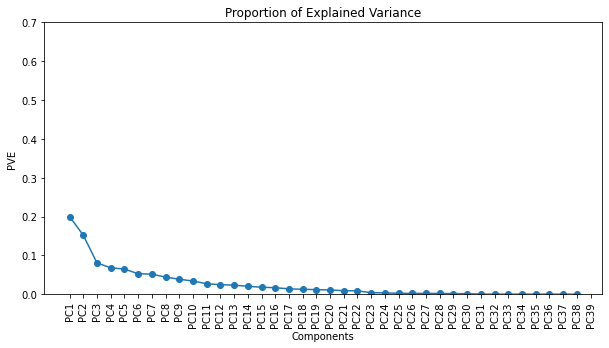

In [64]:
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_,marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,.7)
plt.xticks(np.arange(39),('PC1','PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
                         'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25',
                         'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37',
                         'PC38', 'PC39'), rotation = 'vertical')
plt.title("Proportion of Explained Variance")
plt.show()

In [65]:
pca = PCA(10)
pca.fit(avg_pca)
fd = pca.components_
matrix = np.transpose(fd)
df_fl = pd.DataFrame(data=matrix, index= avg_pca.columns,
                     columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10'])
df_fl

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10
T1_avg_Score,0.261506,0.265598,-0.012970,-0.026177,0.049583,0.008622,0.120716,-0.070669,0.027710,-0.021820
T1_avg_FGM,0.236835,0.238490,-0.032561,-0.069432,0.166435,-0.070722,0.037478,-0.026544,0.133469,0.096023
T1_avg_FGA,0.140915,0.144154,0.045069,-0.206845,0.225774,-0.246261,-0.005251,0.236123,-0.173623,-0.151598
T1_avg_FGM3,0.141930,0.144746,-0.286276,0.020244,0.254546,0.157712,0.038304,-0.006979,-0.204940,-0.211410
T1_avg_FGA3,0.093916,0.084696,-0.249601,-0.038784,0.271475,0.088322,0.002622,0.100024,-0.324702,-0.286369
T1_avg_FTA,0.120929,0.127859,0.270761,0.027405,-0.367428,0.014723,0.227652,-0.120091,-0.065344,-0.112384
T1_avg_FTM,0.134850,0.140781,0.215861,0.057998,-0.370180,0.066833,0.227019,-0.133439,-0.066154,-0.120011
T1_avg_OR,0.110248,0.101795,0.227970,-0.182198,-0.074865,-0.231749,-0.116805,0.300612,-0.216599,-0.087692
T1_avg_DR,0.170557,0.133472,0.028752,0.010503,-0.012668,-0.068941,0.023016,-0.092708,0.209194,0.175281
T1_avg_Ast,0.202486,0.195332,-0.068479,-0.032207,0.162932,-0.011901,-0.001982,-0.098226,0.147030,0.099032


In [66]:
avg_scored = pd.DataFrame(pca.fit_transform(avg_pca))
avg_scored.columns = ['Eig1', 'Eig2', 'Eig3', 'Eig4', 'Eig5', 'Eig6', 'Eig7', 'Eig8', 'Eig9', 'Eig10']
avg_scored.head()

,Eig1,Eig2,Eig3,Eig4,Eig5,Eig6,Eig7,Eig8,Eig9,Eig10
0,3.477749,4.654650,4.006120,1.877016,10.096976,-1.356200,6.484180,2.192548,3.118841,5.958191
1,-11.633910,0.657575,-1.886406,1.898333,-0.424765,-0.373632,-2.324556,1.804887,-0.698470,0.650970
2,5.264112,-2.437390,3.875446,-0.232271,0.368939,-1.870643,1.736658,-1.983050,0.535294,-3.255560
3,5.829140,-1.327390,1.757669,-3.449737,-6.998619,2.885856,4.249048,-1.418403,1.648975,0.907449
4,3.971950,9.037260,0.309471,-1.510138,-1.965242,1.044703,1.355757,4.571276,-1.519019,-0.397826


#### Logistic with PCA

In [67]:
Xtrain, Xtest, ytrain, ytest = train_test_split(avg_scored, y, test_size=0.2, random_state=13)

Model Score: 0.6871345029239766
[[345 155]
 [166 360]]


<AxesSubplot:ylabel='Feature'>

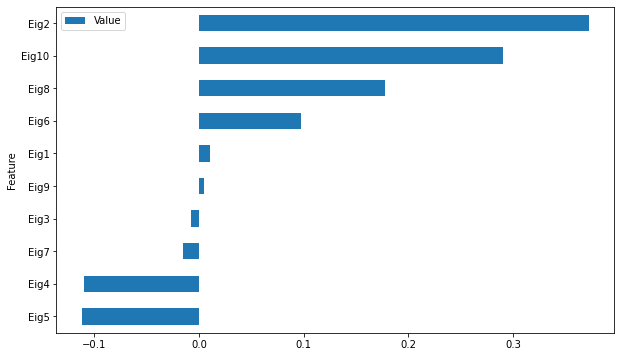

In [68]:
logistic_model(Xtrain, Xtest, ytrain, ytest, avg_scored)

#### Random Forest 

In [69]:
Xtrain, Xtest, ytrain, ytest = train_test_split(avg_scored, y, test_size=0.2, random_state=13)

Model Score: 0.6608187134502924
[[325 175]
 [173 353]]


<AxesSubplot:ylabel='Feature'>

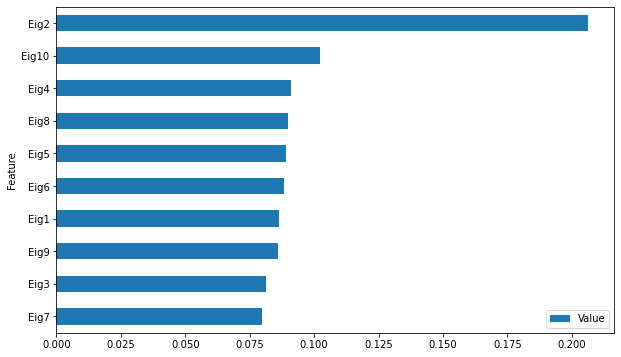

In [70]:
rf_model(Xtrain, Xtest, ytrain, ytest, avg_scored)

## Rolling average

In [71]:
#drops more na since there needs to be 5 games for each team to start
rolling_df = rolling_df.dropna(axis = 0)
rolling_df.shape

(3408, 44)

### Logistic

In [72]:
rolling_df.head()

,T1_Score,T1_roll_Score,T1_roll_FGM,T1_roll_FGA,T1_roll_FGM3,T1_roll_FGA3,T1_roll_FTA,T1_roll_FTM,T1_roll_OR,T1_roll_DR,T1_roll_Ast,T1_roll_TO,T1_roll_Stl,T1_roll_Blk,T1_roll_PF,T1_roll_Pos,T1_roll_OE,T1_roll_DE,T1_roll_TSA,T1_roll_PPP,gameID,team_id_x,T2_Score,T2_roll_Score,T2_roll_FGM,T2_roll_FGA,T2_roll_FGM3,T2_roll_FGA3,T2_roll_FTA,T2_roll_FTM,T2_roll_OR,T2_roll_DR,T2_roll_Ast,T2_roll_TO,T2_roll_Stl,T2_roll_Blk,T2_roll_PF,T2_roll_Pos,T2_roll_OE,T2_roll_DE,T2_roll_TSA,T2_roll_PPP,team_id_y,outcome
1386,75.0,63.9,24.3,59.4,5.9,20.4,13.7,9.4,7.9,22.7,10.4,13.0,6.9,5.0,19.4,80.85,78.99,93.24,0.49,0.79,1385.0,1164.0,62.0,65.7,22.7,60.1,8.2,29.2,17.3,12.1,8.0,24.5,11.3,12.3,7.9,2.3,15.6,78.91,82.91,94.37,0.48,0.83,1203.0,1
1458,60.0,78.9,28.9,57.2,7.5,19.6,17.6,13.6,6.2,25.0,16.9,11.1,5.8,2.4,15.2,86.15,91.26,92.05,0.61,0.91,1457.0,1143.0,72.0,65.6,24.5,55.9,5.4,16.1,15.8,11.2,7.0,25.9,9.8,10.9,5.0,2.2,15.8,73.51,89.79,91.94,0.52,0.90,1365.0,0
1520,75.0,65.0,22.9,61.2,7.9,29.4,15.8,11.3,7.7,24.9,10.6,12.0,8.0,2.6,14.5,79.43,81.43,91.11,0.47,0.81,1519.0,1406.0,89.0,71.4,24.6,56.5,7.1,21.4,21.5,15.1,10.1,23.7,12.3,10.8,7.3,2.3,19.4,72.77,98.72,90.31,0.55,0.99,1164.0,0
1545,57.0,71.6,26.6,57.6,8.9,22.0,13.1,9.5,7.9,24.6,14.0,10.4,5.2,3.0,13.9,76.93,93.09,77.07,0.56,0.93,1544.0,1173.0,62.0,71.6,26.0,54.2,6.5,20.0,18.2,13.1,8.4,24.3,13.7,12.7,5.3,4.0,14.5,75.17,95.78,85.52,0.58,0.96,1439.0,0
1549,91.0,75.0,25.0,59.0,7.1,22.1,24.7,17.9,11.0,25.5,14.7,13.7,5.9,6.2,18.5,76.45,98.18,85.14,0.54,0.98,1548.0,1463.0,77.0,72.2,25.4,62.4,8.5,26.0,18.0,12.9,9.0,26.3,13.0,11.0,4.9,2.8,18.1,78.83,91.30,89.70,0.51,0.91,1233.0,1


In [73]:
#independent and dependent variable
y = rolling_df.outcome
x = rolling_df.drop(['outcome','T1_Score', 'T2_Score', 'gameID'], axis=1)

In [74]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=13)

Model Score: 0.6862170087976539
[[238 110]
 [104 230]]


<AxesSubplot:ylabel='Feature'>

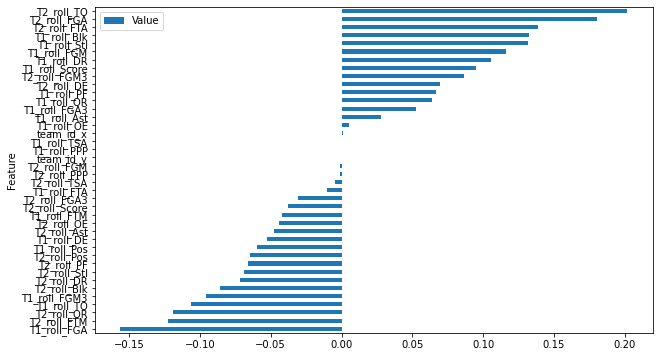

In [75]:
logistic_model(Xtrain, Xtest, ytrain, ytest, x)

### Random Forest 

In [76]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=13)

Model Score: 0.6290322580645161
[[227 121]
 [132 202]]


<AxesSubplot:ylabel='Feature'>

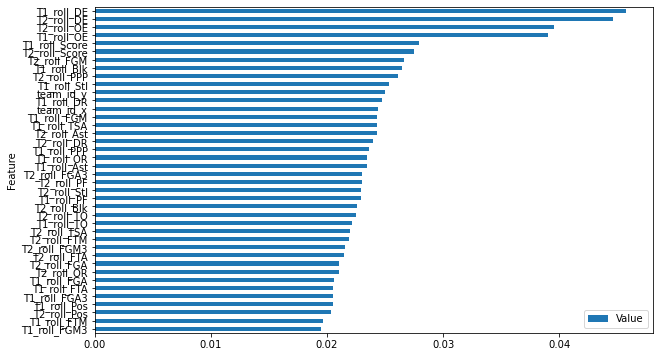

In [77]:
rf_model(Xtrain, Xtest, ytrain, ytest, x)

### Rolling Average with PCA

In [78]:
rolling_df = rolling_df.dropna(axis = 0)

scaler = StandardScaler()

y = rolling_df['outcome']

rolling_pca = rolling_df.drop(['outcome','T1_Score', 'T2_Score', 'gameID', 'team_id_x', 'team_id_y'], axis=1)

In [79]:
#scaling data
rolling_pca = pd.DataFrame.from_records(scaler.fit_transform(rolling_pca), 
                                     columns = rolling_pca.columns)
rolling_pca.head()

,T1_roll_Score,T1_roll_FGM,T1_roll_FGA,T1_roll_FGM3,T1_roll_FGA3,T1_roll_FTA,T1_roll_FTM,T1_roll_OR,T1_roll_DR,T1_roll_Ast,T1_roll_TO,T1_roll_Stl,T1_roll_Blk,T1_roll_PF,T1_roll_Pos,T1_roll_OE,T1_roll_DE,T1_roll_TSA,T1_roll_PPP,T2_roll_Score,T2_roll_FGM,T2_roll_FGA,T2_roll_FGM3,T2_roll_FGA3,T2_roll_FTA,T2_roll_FTM,T2_roll_OR,T2_roll_DR,T2_roll_Ast,T2_roll_TO,T2_roll_Stl,T2_roll_Blk,T2_roll_PF,T2_roll_Pos,T2_roll_OE,T2_roll_DE,T2_roll_TSA,T2_roll_PPP
0,-1.107377,-0.402004,0.596827,-0.961585,-0.367029,-1.188630,-1.269262,-0.243332,-0.294520,-1.178353,0.528709,0.340324,1.592499,1.282588,0.749949,-2.252693,0.505100,-1.432407,-2.243736,-0.758192,-1.083015,0.775117,0.554820,2.049869,-0.025010,-0.158138,-0.182010,0.507092,-0.750314,0.162991,1.026628,-0.820523,-0.556595,0.326033,-1.480530,0.722508,-1.691532,-1.459264
1,1.519374,1.696888,-0.068952,0.092753,-0.593333,0.061801,0.449098,-1.190565,0.773223,1.879658,-0.542908,-0.416068,-0.718363,-0.747249,1.920033,0.075741,0.276565,1.932116,0.027097,-0.775214,-0.291030,-0.454732,-1.267664,-1.547614,-0.504573,-0.529049,-0.753392,1.138650,-1.462179,-0.616464,-0.955047,-0.906888,-0.458112,-0.836339,-0.197568,0.249607,-0.570859,-0.155680
2,-0.914749,-1.040797,1.141555,0.356338,2.178885,-0.515321,-0.491908,-0.354771,0.726800,-1.084260,-0.035300,1.096715,-0.540604,-1.085555,0.436454,-1.789663,0.096041,-1.993160,-1.865264,0.212060,-0.247031,-0.279039,-0.161156,-0.092143,1.317765,1.078234,1.017890,0.146201,-0.275737,-0.672139,0.616627,-0.820523,1.314576,-0.995627,1.467673,-0.067606,0.269646,1.520356
3,0.241022,0.647442,0.052098,1.015300,0.085578,-1.381004,-1.228348,-0.243332,0.587529,0.515314,-0.937715,-0.828645,-0.185087,-1.375532,-0.115473,0.423013,-2.600292,0.530231,0.405569,0.246104,0.368958,-0.952528,-0.551688,-0.476607,0.262727,0.253986,0.046542,0.416869,0.388671,0.385692,-0.750046,0.647690,-1.098249,-0.479017,0.919430,-0.999786,1.110150,0.961677
4,0.836419,-0.082607,0.475776,-0.170831,0.113866,2.338226,2.208371,1.483976,1.005342,0.844639,0.923515,-0.347305,2.659051,0.847623,-0.221442,1.388924,-1.050476,-0.030522,1.351750,0.348236,0.104963,1.448606,0.750086,1.171095,0.198786,0.171561,0.389371,1.319096,0.056467,-0.560788,-1.023380,-0.388695,0.674438,0.308812,0.084013,-0.186318,-0.851028,0.030546


In [80]:
pca=PCA()
pca.fit(rolling_pca)

PCA()

In [81]:
fd = pca.components_
matrix = np.transpose(fd)
df_fl = pd.DataFrame(data=matrix, index=rolling_pca.columns,
                     columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', 
                              'Z15','Z16', 'Z17', 'Z18', 'Z19', 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z25', 'Z26', 'Z27', 
                              'Z28','Z29', 'Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z37', 'Z38'])
df_fl

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,Z38
T1_roll_Score,-0.271996,0.294871,0.055659,0.019450,0.015505,0.119683,-0.037296,-0.060726,0.028252,0.041273,0.065154,0.052203,0.033400,0.066425,-0.042517,0.004951,0.047097,-0.029926,-0.020509,-0.059865,0.107759,-0.072003,-0.037327,-0.037129,-0.001210,0.007750,-0.020816,-0.011099,-0.010634,-0.016469,-0.140607,-0.169830,0.412062,0.020802,-0.096748,-0.025236,7.366085e-01,-0.000000e+00
T1_roll_FGM,-0.241047,0.260634,-0.005157,0.153539,-0.107315,0.077557,0.023712,-0.047307,0.126986,-0.061034,0.196107,0.144364,0.094289,0.127150,-0.142718,0.017813,-0.088379,-0.015647,0.023112,-0.125609,0.114381,-0.126095,-0.014971,-0.015789,0.056272,-0.039860,0.141993,0.103205,0.147780,0.292687,-0.120550,-0.143499,0.380505,0.014147,-0.089077,-0.022675,-5.654083e-01,-7.201679e-16
T1_roll_FGA,-0.122099,0.149017,0.076289,0.277748,-0.146240,0.111159,0.231012,0.248681,-0.138856,0.103535,0.000600,0.314210,-0.042720,0.237795,-0.095989,0.043845,0.188357,-0.068046,-0.061673,0.083172,0.000979,0.091215,-0.055089,-0.067359,0.225491,0.291264,-0.154070,-0.096493,-0.056637,-0.035850,0.322371,0.433526,-0.014228,-0.001494,-0.022214,-0.014918,5.828671e-16,3.392479e-16
T1_roll_FGM3,-0.163381,0.174956,-0.204178,0.038403,-0.153469,0.086339,-0.270035,0.137813,-0.192688,0.152672,-0.215107,-0.155421,-0.116356,-0.181827,0.130172,-0.028484,0.015733,0.001713,0.038674,-0.051678,0.048638,-0.094548,0.037703,0.089711,-0.342814,0.142104,-0.558738,-0.215940,-0.004698,-0.049816,-0.037246,-0.060804,0.112557,0.007362,-0.030974,-0.008994,-1.957511e-01,3.166318e-17
T1_roll_FGA3,-0.110184,0.116643,-0.157299,0.087348,-0.166753,0.106566,-0.185269,0.258501,-0.316235,0.214505,-0.315186,-0.132758,-0.167647,-0.141312,0.166285,-0.009240,0.185719,-0.018445,0.024018,0.056023,-0.039539,0.030156,-0.105009,-0.113792,0.163386,-0.242371,0.510151,0.214880,0.029175,0.070543,-0.007969,0.004773,0.000324,-0.000042,0.000848,0.000523,-5.551115e-17,-4.703807e-17
T1_roll_FTA,-0.074318,0.098206,0.310375,-0.215616,0.313743,0.098439,0.094759,-0.134788,-0.038186,0.094843,-0.087439,-0.056050,-0.040619,-0.003424,0.073190,0.018798,0.227900,-0.021088,-0.105150,0.141459,0.032313,0.156992,-0.109534,-0.043046,-0.319163,-0.187366,-0.122551,0.060974,0.307610,0.496509,0.146779,0.188423,-0.032959,-0.005904,-0.007340,-0.007682,1.249001e-16,1.995431e-17
T1_roll_FTM,-0.101758,0.112890,0.266056,-0.253749,0.323963,0.086930,0.037998,-0.142603,-0.042088,0.111091,-0.065911,-0.040433,-0.018817,0.040060,0.075787,-0.002693,0.258760,-0.042920,-0.113375,0.117479,0.016439,0.116611,-0.083769,-0.114132,0.109104,0.001361,0.043632,-0.076942,-0.286948,-0.532434,-0.089194,-0.101687,0.210462,0.018660,-0.047061,-0.012714,-3.152823e-01,-1.056665e-16
T1_roll_OR,-0.040823,0.066448,0.251819,0.179516,0.040268,-0.104470,0.348300,0.288690,-0.135177,0.009478,-0.124653,0.038938,-0.132869,-0.038534,-0.143603,0.115232,-0.281518,0.099023,-0.200575,-0.072037,0.314431,0.014967,0.225875,0.250076,-0.302139,-0.312851,0.086290,0.048591,-0.059420,-0.202942,-0.018238,-0.029326,-0.024238,0.004026,0.004649,0.001195,-1.110223e-16,-1.116515e-16
T1_roll_DR,-0.166037,0.146455,0.023950,0.048402,0.001174,-0.066480,0.112376,-0.172877,0.149566,-0.337952,-0.330783,0.109195,-0.312430,-0.045032,-0.139791,0.150372,0.213123,-0.075926,0.233742,0.052922,-0.500921,-0.119002,0.283925,0.204973,-0.033939,-0.046232,0.033253,-0.003280,-0.018616,-0.015945,-0.002232,-0.007480,0.003432,-0.000515,-0.001217,-0.000042,-2.775558e-17,8.451003e-17
T1_roll_Ast,-0.181266,0.213742,-0.011341,0.150084,-0.138213,-0.004143,-0.069547,-0.109614,0.114305,-0.046824,0.033803,-0.187711,0.047105,-0.095084,-0.019908,0.068273,-0.415974,0.195505,-0.184226,0.434222,-0.260906,0.532182,-0.061254,-0.036050,0.045549,0.002693,-0.037669,0.010060,0.002394,-0.033882,-0.000798,0.003413,-0.003936,0.001815,0.000765,-0.001982,3.330669e-16,-5.075220e-17


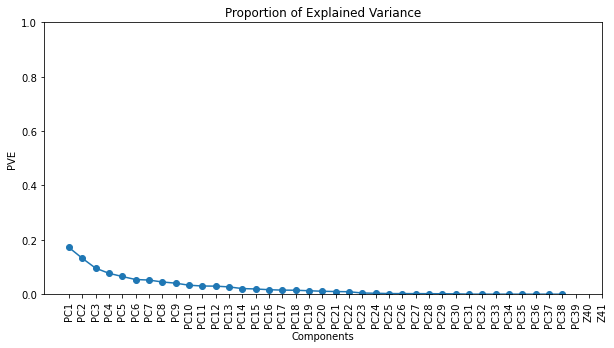

In [82]:
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_,marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,1)
plt.xticks(np.arange(41),('PC1','PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
                         'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25',
                         'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37',
                         'PC38', 'PC39', 'Z40', 'Z41'), rotation = 'vertical')
plt.title("Proportion of Explained Variance")
plt.show()

In [83]:
pca= PCA(10)
pca.fit(rolling_pca)

fd = pca.components_
matrix = np.transpose(fd)
df_fl = pd.DataFrame(data=matrix, index=rolling_pca.columns,
                     columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10'])
df_fl

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10
T1_roll_Score,-0.271996,0.294871,0.055659,0.019447,0.015513,0.119705,-0.037241,-0.060736,0.028186,0.041517
T1_roll_FGM,-0.241047,0.260634,-0.005157,0.153533,-0.107300,0.077593,0.023811,-0.047326,0.126867,-0.060610
T1_roll_FGA,-0.122099,0.149017,0.076289,0.277751,-0.146247,0.111146,0.230970,0.248690,-0.138820,0.103478
T1_roll_FGM3,-0.163381,0.174955,-0.204178,0.038402,-0.153466,0.086339,-0.270010,0.137806,-0.192688,0.152676
T1_roll_FGA3,-0.110184,0.116642,-0.157299,0.087352,-0.166764,0.106533,-0.185329,0.258511,-0.316129,0.214146
T1_roll_FTA,-0.074318,0.098206,0.310376,-0.215612,0.313734,0.098429,0.094693,-0.134771,-0.038135,0.094684
T1_roll_FTM,-0.101758,0.112890,0.266056,-0.253745,0.323953,0.086917,0.037933,-0.142588,-0.042029,0.110901
T1_roll_OR,-0.040823,0.066449,0.251819,0.179504,0.040295,-0.104366,0.348450,0.288673,-0.135478,0.010683
T1_roll_DR,-0.166037,0.146454,0.023949,0.048418,0.001137,-0.066630,0.112178,-0.172858,0.149956,-0.339475
T1_roll_Ast,-0.181266,0.213743,-0.011339,0.150095,-0.138242,-0.004159,-0.069755,-0.109559,0.114423,-0.047187


In [84]:
rolling_scored = pd.DataFrame(pca.fit_transform(rolling_pca))
rolling_scored.columns = ['Eig1', 'Eig2', 'Eig3', 'Eig4', 'Eig5', 'Eig6', 'Eig7', 'Eig8', 'Eig9', 'Eig10']
rolling_scored.head()

,Eig1,Eig2,Eig3,Eig4,Eig5,Eig6,Eig7,Eig8,Eig9,Eig10
0,3.599604,-1.253879,-0.245431,3.241414,-0.266939,1.651456,1.095594,-0.752123,-0.786127,-1.194216
1,-0.659371,3.604876,-1.010387,-0.750080,-1.056306,0.343415,-0.784747,-2.004735,2.238901,0.285014
2,0.625099,-2.032538,0.379718,0.109306,-3.706951,0.667914,0.477437,0.777192,-2.066418,-0.508777
3,-1.927027,0.265157,-1.315308,-0.250742,-2.183923,-2.630908,0.057680,0.944891,1.384292,-0.339053
4,-2.498029,1.149405,2.603790,-0.088705,2.590267,0.085538,1.629238,-0.627502,-1.214782,-1.009439


#### Logitstic

In [85]:
Xtrain, Xtest, ytrain, ytest = train_test_split(rolling_scored, y, test_size=0.2, random_state=13)

Model Score: 0.6524926686217009
[[227 121]
 [116 218]]


<AxesSubplot:ylabel='Feature'>

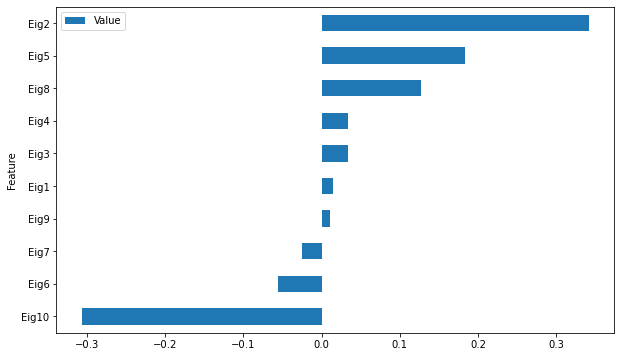

In [86]:
logistic_model(Xtrain, Xtest, ytrain, ytest, rolling_scored)

#### Random Forest

In [87]:
Xtrain, Xtest, ytrain, ytest = train_test_split(rolling_scored, y, test_size=0.2, random_state=13)

Model Score: 0.624633431085044
[[213 135]
 [121 213]]


<AxesSubplot:ylabel='Feature'>

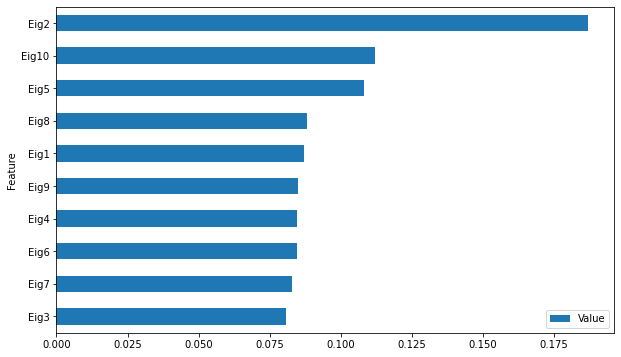

In [88]:
rf_model(Xtrain, Xtest, ytrain, ytest, rolling_scored)